In [2]:
import typing
import numpy as np
import pandas as pd
import interpretable as inter
import interpretable_linear_data as interData
import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt 
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import NonNeg 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

from scipy.optimize import curve_fit
from pandas import Grouper as tg

scaler = StandardScaler()

In [4]:
# load clean data
#%store -r dataf
dfUST = pd.read_csv('dfUST.csv')
# we store the desired data
mid = dfUST['mid'].copy()
returns = dfUST['returns'].copy()
qty_signed = dfUST['qty_signed'].copy()
epsilons = qty_signed.apply(lambda x: np.sign(x)).copy()
qty_signed_log = qty_signed.apply(lambda x: np.sign(x)*np.log(1+np.abs(x))).copy()

# we set the learning lag parameter
N = len(mid)
max_lag = 1000

# we define the regression matrix for each method of learning
L = 500

AOW = inter.regression_matrix(qty_signed.values, L)
Alog = inter.regression_matrix(qty_signed_log.values, L)

# we normalize for the training 
row_stdOW = AOW.std(axis=1)
std_matrixOW = AOW / row_stdOW[:, np.newaxis]

row_stdlog = Alog.std(axis=1)
std_matrixlog = Alog / row_stdlog[:, np.newaxis]

Y = returns.values[L:].reshape(-1,1)




$\underline{\text{Curve fitting:}}$

In [5]:
def curve_fittingPL(v,a,b):
    return a*np.power(v,-b)

def curve_fittingPLB(v,a,b):
    return a*np.power(a+v,-b)

def curve_fittingExpo(v,rho):
    return np.exp(-rho*v) 

$\underline{\text{Plot functions:}}$

In [6]:
#we plot the loss during the training
def plot_loss(ax, history):
    ax.semilogy(history.history['loss'], label='loss')
    ax.semilogy(history.history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')
    ax.legend()
    ax.grid(True)
    
def plot_kernels(kernels, ax):
    for kernel in kernels: 
        ax.plot(kernels[kernel][1:], label = 'kernel approx with kernel:'+str(kernel))
        ax.set_title('regressed kernel ')
        ax.set_xlabel('t')
        ax.set_ylabel('Price ($)')
        ax.set_xlim((1,500))
        ax.legend()

$\underline{\text{Tests:}}$

In [7]:
reg_log_USB = LinearRegression().fit(std_matrixlog, Y)
Glog_approx_USB = reg_log_USB.coef_.cumsum()

reg_OW_USB = LinearRegression().fit(std_matrixOW, Y)
GOW_approx_USB = reg_OW_USB.coef_.cumsum()

$\underline{\text{Results:}}$

In [8]:
paramsOW, cov = curve_fit(curve_fittingPLB, np.arange(5, L+1), GOW_approx_USB[5:] )
approOW = curve_fittingPLB(np.arange(1, N+1), *paramsOW)

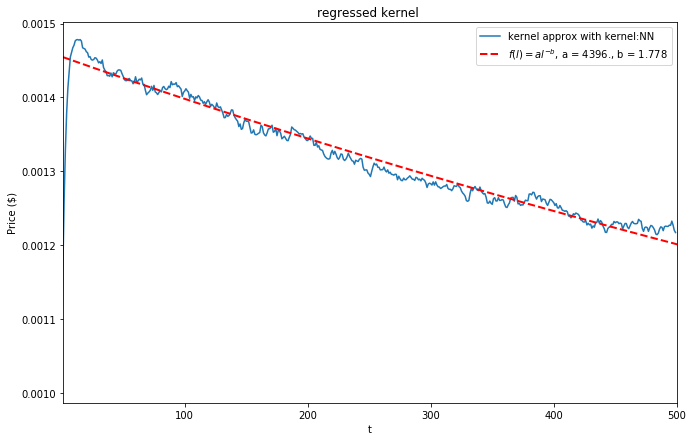

In [9]:
kernels = {'NN': GOW_approx_USB}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)
ax.plot(np.arange(1,max_lag+2), approOW[:max_lag+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(paramsOW[0])[:5] + ', b = ' + str(paramsOW[1])[:5] )
ax.legend()

#plt.yscale('log')
#plt.ylim((1.1e-3,1.6*1e-3))


plt.savefig('graphs_10YUSB/OW_one_kernel_non_linear_regression_10YUSB.png')

In [10]:
returnsapproxOW_USB = reg_OW_USB.predict(std_matrixOW) # equivalent to the linear model with F as the identity
R2_OWModel_USB = r2_score(Y, returnsapproxOW_USB)

In [11]:
print('R^2 train (returns): %.3f' % R2_OWModel_USB )

R^2 train (returns): 0.063


In [12]:
paramslog, cov = curve_fit(curve_fittingPLB, np.arange(2, L+1), Glog_approx_USB[2:] )
approlog = curve_fittingPLB(np.arange(1, N+1), *paramslog)

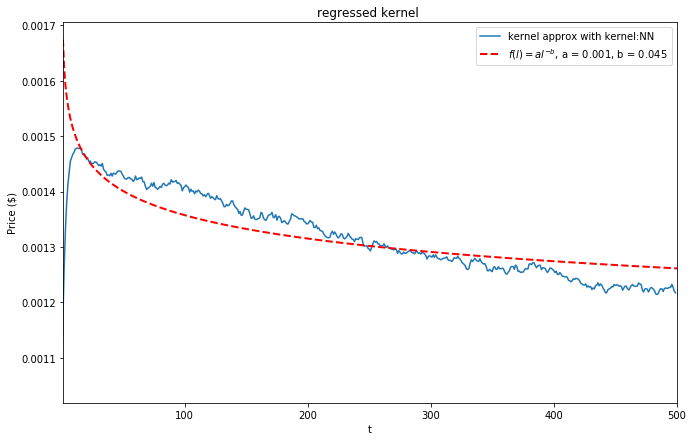

In [13]:
kernels = {'NN': Glog_approx_USB}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)
ax.plot(np.arange(1,max_lag+2), approlog[:max_lag+1], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(paramslog[0])[:5] + ', b = ' + str(paramslog[1])[:5] )
ax.legend()

#plt.yscale('log')
#plt.ylim((5e-4,1.5e-3))


plt.savefig('graphs_10YUSB/log_one_kernel_non_linear_regression_10YUSB.png')

In [14]:
returnsapproxlog_USB = reg_log_USB.predict(std_matrixlog) # 
R2_LogModel_USB = r2_score(Y, returnsapproxlog_USB)

In [15]:
print('R^2 train (returns): %.3f' % r2_score(Y, returnsapproxlog_USB) )

R^2 train (returns): 0.063


In [19]:
(np.var(returnsapproxlog_USB.cumsum())/np.var(Y.cumsum()))

2.404588542333412

In [17]:
synthetic_variogram_Glog_approx_USB = inter.variogram2(returnsapproxlog_USB.cumsum())
synthetic_variogram_GOW_approx_USB = inter.variogram2(returnsapproxOW_USB.cumsum())

In [18]:
%store  Glog_approx_USB
% store  synthetic_variogram_Glog_approx_USB
% store  returnsapproxlog_USB
% store R2_LogModel_USB

%store  GOW_approx_USB
% store  synthetic_variogram_GOW_approx_USB
% store  returnsapproxOW_USB
% store R2_OWModel_USB

Stored 'Glog_approx_USB' (ndarray)
Stored 'synthetic_variogram_Glog_approx_USB' (Series)
Stored 'returnsapproxlog_USB' (ndarray)
Stored 'R2_LogModel_USB' (float64)
Stored 'GOW_approx_USB' (ndarray)
Stored 'synthetic_variogram_GOW_approx_USB' (Series)
Stored 'returnsapproxOW_USB' (ndarray)
Stored 'R2_OWModel_USB' (float64)
